<a href="https://colab.research.google.com/github/spooki-chan/CS-31_SDGP/blob/sub/RecommedationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hybrid Recommendation System


1. Import our dependencies
2. Load dataset
3. Understand dataset
4. Pre-processing steps (We will perform the pre-processing steps as and when needed)
5. Build recommendation system
   5.1 Simple recommendation system
        5.1.1 Implement model
        5.1.2 Evaluate Result
    5.2 Content based recommendation system
        5.2.1 Implement model
        5.2.2 Evaluate Result
    5.3 CF based recommendation system
        5.3.1 Implement model
        5.3.2 Evaluate Result
    5.4 Hybrid recommendation system
        5.4.1 Implement model
        5.4.2 Evaluate Result

In [1]:
# Importing frameworks
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import warnings; warnings.simplefilter('ignore')



In [2]:
df = pd.read_csv("newfood.csv")

In [3]:
df.head()

,id,title,pricePerServing,weightPerServing,vegetarian,vegan,glutenFree,dairyFree,sustainable,veryHealthy,...,Vitamin D/µg,Vitamin K/µg,Vitamin C/mg,Alcohol/g,Caffeine/g,stars,popularity,userId,tfdbId,recipeId
0,1,Fried Anchovies with Sage,5.6051,226,False,False,False,True,False,False,...,0.29,0.00,0.00,0.0,0.0,3,150.437577,1,1,1915
1,2,Anchovies Appetizer With Breadcrumbs & Scallions,0.8206,33,False,False,False,True,False,False,...,0.00,7.18,0.00,0.0,0.0,1,139.082615,1,2,1916
2,3,"Carrots, Cauliflower And Anchovies",4.3800,364,False,False,False,True,False,True,...,0.00,104.27,32.60,0.0,0.0,4,107.376788,1,3,1918
3,4,Bap Story Stir Fried Anchovies (Myulchi Bokkeum),8.1122,711,False,False,True,True,False,True,...,6.24,16.02,3.88,0.0,0.0,3,112.312950,1,4,1919
4,5,"Bread, Butter And Anchovies",0.2557,36,False,False,False,False,False,False,...,0.00,2.21,0.00,0.0,0.0,5,43.926995,1,5,1920


Removing Unwanted Columns In the Dataset

In [4]:
df.drop(labels=['vegetarian','vegan', 'glutenFree', 'dairyFree', 'sustainable', 'weightPerServing','pricePerServing', 'gaps', 'lowFodmap', 'ketogenic'],axis=1, inplace=True)
df.drop(labels=['whole30','spoonacularScore', 'Vitamin B5/mg', 'Vitamin B6/mg', 'healthScore','percentProtein', 'percentFat', 'Magnesium/mg', 'Vitamin B12/µg'],axis=1, inplace=True)
df.drop(labels=['percentCarbs','Zinc/mg', 'Manganese/mg', 'Fiber/g', 'Vitamin E/mg','Vitamin B1/mg', 'Folate/µg', 'Potassium/mg', 'Copper/mg','Vitamin A/IU','Vitamin D/µg','Vitamin K/µg'],axis=1, inplace=True)
df.drop(labels=['Fat/g','Saturated Fat/g', 'Carbohydrates/g','Cholesterol/mg','Sodium/mg','Protein/g','Vitamin B3/mg','Selenium/µg','Phosphorus/mg','Iron/mg','Vitamin B2/mg','Calcium/mg','Vitamin C/mg','Alcohol/g','Caffeine/g'],axis=1, inplace=True)


In [5]:
df.head()

,id,title,veryHealthy,veryPopular,readyInMinutes,spoonacularSourceUrl,image,aggregateLikes,dishTypes,ingredients,calories,Sugar/g,stars,popularity,userId,tfdbId,recipeId
0,1,Fried Anchovies with Sage,False,False,45,https://spoonacular.com/fried-anchovies-with-s...,https://spoonacular.com/recipeImages/1-556x370...,1354,Maindish,"anchovies,baking powder,egg,flour,sage leaves,...",384.09,0.17,3,150.437577,1,1,1915
1,2,Anchovies Appetizer With Breadcrumbs & Scallions,False,False,15,https://spoonacular.com/anchovies-appetizer-wi...,https://spoonacular.com/recipeImages/2-556x370...,1535,Starter,"anchovies,bread,garlic clove,olive oil,scallions",57.07,0.50,1,139.082615,1,2,1916
2,3,"Carrots, Cauliflower And Anchovies",True,False,45,https://spoonacular.com/carrots-cauliflower-an...,https://spoonacular.com/recipeImages/3-556x370...,1535,Maindish,"acini di pepe,almonds,anchovies,carrots,caulif...",942.08,11.09,4,107.376788,1,3,1918
3,4,Bap Story Stir Fried Anchovies (Myulchi Bokkeum),True,False,45,https://spoonacular.com/bap-story-stir-fried-a...,https://spoonacular.com/recipeImages/4-556x370...,4245,Maindish,"anchovies,baby-back ribs,cooking oil,frying oi...",1697.23,14.09,3,112.312950,1,4,1919
4,5,"Bread, Butter And Anchovies",False,False,3,https://spoonacular.com/bread-butter-and-ancho...,https://spoonacular.com/recipeImages/5-556x370...,420,Maindish,"bread,capers,salted anchovies,unsalted butter",112.75,1.71,5,43.926995,1,5,1920


In [6]:
df['recommend'] = np.nan
df['recommend'] = df['recommend'].astype('str')

df["stars"] = df["stars"].astype("int64", errors='ignore')

for i in df['veryHealthy'].index: 
  if(False==df['veryHealthy'][i] ): 
    df['recommend'][i]='No' 
  elif(True==df['veryHealthy'][i] ): 
    df['recommend'][i]='Yes'

In [7]:
df.head()

,id,title,veryHealthy,veryPopular,readyInMinutes,spoonacularSourceUrl,image,aggregateLikes,dishTypes,ingredients,calories,Sugar/g,stars,popularity,userId,tfdbId,recipeId,recommend
0,1,Fried Anchovies with Sage,False,False,45,https://spoonacular.com/fried-anchovies-with-s...,https://spoonacular.com/recipeImages/1-556x370...,1354,Maindish,"anchovies,baking powder,egg,flour,sage leaves,...",384.09,0.17,3,150.437577,1,1,1915,No
1,2,Anchovies Appetizer With Breadcrumbs & Scallions,False,False,15,https://spoonacular.com/anchovies-appetizer-wi...,https://spoonacular.com/recipeImages/2-556x370...,1535,Starter,"anchovies,bread,garlic clove,olive oil,scallions",57.07,0.50,1,139.082615,1,2,1916,No
2,3,"Carrots, Cauliflower And Anchovies",True,False,45,https://spoonacular.com/carrots-cauliflower-an...,https://spoonacular.com/recipeImages/3-556x370...,1535,Maindish,"acini di pepe,almonds,anchovies,carrots,caulif...",942.08,11.09,4,107.376788,1,3,1918,Yes
3,4,Bap Story Stir Fried Anchovies (Myulchi Bokkeum),True,False,45,https://spoonacular.com/bap-story-stir-fried-a...,https://spoonacular.com/recipeImages/4-556x370...,4245,Maindish,"anchovies,baby-back ribs,cooking oil,frying oi...",1697.23,14.09,3,112.312950,1,4,1919,Yes
4,5,"Bread, Butter And Anchovies",False,False,3,https://spoonacular.com/bread-butter-and-ancho...,https://spoonacular.com/recipeImages/5-556x370...,420,Maindish,"bread,capers,salted anchovies,unsalted butter",112.75,1.71,5,43.926995,1,5,1920,No


STAR COMPARE WITH RECOMMENDED

In [8]:
df.columns

Index(['id', 'title', 'veryHealthy', 'veryPopular', 'readyInMinutes',
       'spoonacularSourceUrl', 'image', 'aggregateLikes', 'dishTypes',
       'ingredients', 'calories', 'Sugar/g', 'stars', 'popularity', 'userId',
       'tfdbId', 'recipeId', 'recommend'],
      dtype='object')



*   Id : for food numbers
*   title : Food name
*   veryHealthy :
*   veryPopular :
*   readyInMinutes :
*   image :
*   dishTypes :
*   ingredients :
*   calories :
*   stars :
*   recommend :












In [9]:
df.iloc[0:3].transpose()

,0,1,2
id,1,2,3
title,Fried Anchovies with Sage,Anchovies Appetizer With Breadcrumbs & Scallions,"Carrots, Cauliflower And Anchovies"
veryHealthy,False,False,True
veryPopular,False,False,False
readyInMinutes,45,15,45
spoonacularSourceUrl,https://spoonacular.com/fried-anchovies-with-s...,https://spoonacular.com/anchovies-appetizer-wi...,https://spoonacular.com/carrots-cauliflower-an...
image,https://spoonacular.com/recipeImages/1-556x370...,https://spoonacular.com/recipeImages/2-556x370...,https://spoonacular.com/recipeImages/3-556x370...
aggregateLikes,1354,1535,1535
dishTypes,Maindish,Starter,Maindish
ingredients,"anchovies,baking powder,egg,flour,sage leaves,...","anchovies,bread,garlic clove,olive oil,scallions","acini di pepe,almonds,anchovies,carrots,caulif..."


In [10]:
df.shape

(1722, 18)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1722 entries, 0 to 1721
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1722 non-null   int64  
 1   title                 1722 non-null   object 
 2   veryHealthy           1722 non-null   bool   
 3   veryPopular           1722 non-null   bool   
 4   readyInMinutes        1722 non-null   int64  
 5   spoonacularSourceUrl  1722 non-null   object 
 6   image                 1718 non-null   object 
 7   aggregateLikes        1722 non-null   int64  
 8   dishTypes             1722 non-null   object 
 9   ingredients           1722 non-null   object 
 10  calories              1722 non-null   float64
 11  Sugar/g               1722 non-null   float64
 12  stars                 1722 non-null   int64  
 13  popularity            1722 non-null   float64
 14  userId                1722 non-null   int64  
 15  tfdbId               

<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mstyle mathsize="1.2em">
    <mi>W</mi>
    <mi>e</mi>
    <mi>i</mi>
    <mi>g</mi>
    <mi>h</mi>
    <mi>t</mi>
    <mi>e</mi>
    <mi>d</mi>
    <mstyle>
      <mspace width="0.278em"></mspace>
    </mstyle>
    <mi>R</mi>
    <mi>a</mi>
    <mi>t</mi>
    <mi>i</mi>
    <mi>n</mi>
    <mi>g</mi>
    <mo stretchy="false">(</mo>
    <mi>W</mi>
    <mi>R</mi>
    <mo stretchy="false">)</mo>
    <mo>=</mo>
    <mo stretchy="false">(</mo>
    <mfrac>
      <mi>v</mi>
      <mrow>
        <mi>v</mi>
        <mo>+</mo>
        <mi>m</mi>
      </mrow>
    </mfrac>
    <mo>.</mo>
    <mi>R</mi>
    <mo stretchy="false">)</mo>
    <mo>+</mo>
    <mo stretchy="false">(</mo>
    <mfrac>
      <mi>m</mi>
      <mrow>
        <mi>v</mi>
        <mo>+</mo>
        <mi>m</mi>
      </mrow>
    </mfrac>
    <mo>.</mo>
    <mi>C</mi>
    <mo stretchy="false">)</mo>
  </mstyle>
</math>







where,
v is the number of aggregate likes for the recipes
m is the minimum aggregate likes required to be listed in the chart
R is the average stars of the movie
C is the mean vote across the whole report

In [12]:
# this is V
aggregateLike = df[df['aggregateLikes'].notnull()]['aggregateLikes'].astype('int')

# this is R
star = df[df['stars'].notnull()]['stars'].astype('int')

# this is C
C = star.mean()
C






3.9204413472706157

The next step, we need to determine an appropriate value for m, the minimum aggregateLikes required to be listed in the chart.

We will use 95th percentile as our cutoff. In other words, for a recipes to feature in the charts, it must have more aggregateLikes than at least 95% of the recipes in the list.

In [13]:
m = aggregateLike.quantile(0.95)
m

3233.8499999999995

In [14]:
df['weighted_average']=((star*aggregateLike)+ (C*m))/(aggregateLike+m)

In [15]:
qualified = df[(df['aggregateLikes'] >= m) & 
               (df['aggregateLikes'].notnull()) & 
               (df['stars'].notnull())][['title', 
                                                'calories', 
                                                'stars', 
                                                'aggregateLikes', 
                                                'popularity', 
                                                'dishTypes']]

qualified['aggregateLikes'] = qualified['aggregateLikes'].astype('int')
qualified['stars'] = qualified['stars'].astype('int')
qualified.shape

(87, 6)

In [16]:
def weighted_rating(x):
    v = x['aggregateLikes']
    R = x['stars']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [17]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [18]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [19]:
recipe_ranking=df.sort_values('weighted_average',ascending=False)
recipe_ranking[['title', 'aggregateLikes', 'stars', 'weighted_average', 'calories']].head(20)

,title,aggregateLikes,stars,weighted_average,calories
190,Bagna Cauda Dip With Assorted Vegetables,9635,5,4.728715,1126.02
1014,"Fish With Olives, Pine Nuts, Basil And Wine",9567,5,4.727274,26.01
77,"Roasted Brussels Sprouts With Capers, Walnuts ...",6423,5,4.638481,611.24
1156,Bluefish (or Swordfish) With Preserved Lemons,5244,5,4.588206,371.76
489,"Spaghetti With Caramelized Onions, Anchovies, ...",5235,5,4.587768,1117.33
78,Labneh With Chilli And Anchovy,4646,5,4.556955,505.60
428,Salsa-Piqino,4645,5,4.556898,574.52
1587,Poached Salmon With Corn And White Winebutter ...,4524,5,4.549987,980.06
80,Pasta With Anchovy Bread Crumb Topping,4342,5,4.539176,650.02
988,Whataes your sodium style,4254,5,4.533761,433.57


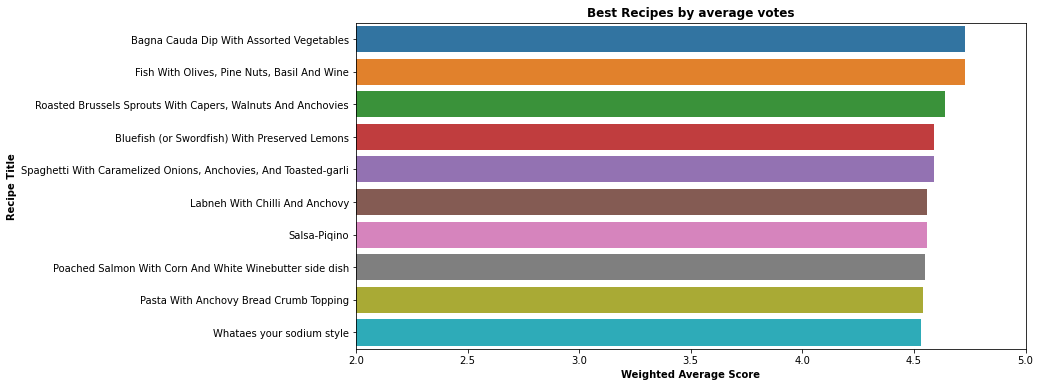

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

weight_average=recipe_ranking.sort_values('weighted_average',ascending=False)
plt.figure(figsize=(12,6))
axis1=sns.barplot(x=weight_average['weighted_average'].head(10), y=weight_average['title'].head(10), data=weight_average)
plt.xlim(2, 5)
plt.title('Best Recipes by average votes', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Recipe Title', weight='bold')
plt.savefig('best_recipes.png')

In [21]:
qualified.head(15)

,title,calories,stars,aggregateLikes,popularity,dishTypes,wr
190,Bagna Cauda Dip With Assorted Vegetables,1126.02,5,9635,89.938296,Starter,4.728715
1014,"Fish With Olives, Pine Nuts, Basil And Wine",26.01,5,9567,18.600490,Starter,4.727274
77,"Roasted Brussels Sprouts With Capers, Walnuts ...",611.24,5,6423,128.655964,Maindish,4.638481
1156,Bluefish (or Swordfish) With Preserved Lemons,371.76,5,5244,25.219805,Maindish,4.588206
489,"Spaghetti With Caramelized Onions, Anchovies, ...",1117.33,5,5235,10.706613,Maindish,4.587768
78,Labneh With Chilli And Anchovy,505.60,5,4646,94.199316,Maindish,4.556955
428,Salsa-Piqino,574.52,5,4645,59.113174,Maindish,4.556898
1587,Poached Salmon With Corn And White Winebutter ...,980.06,5,4524,30.380747,Maindish,4.549987
80,Pasta With Anchovy Bread Crumb Topping,650.02,5,4342,77.178973,Maindish,4.539176
988,Whataes your sodium style,433.57,5,4254,3.314004,Maindish,4.533761


Let us now construct our function that builds charts for particular maindishes.

For this, we relax our default conditions to the 85th percentile instead of 95.

In [22]:
'''
>>> s
     a   b
one  1.  2.
two  3.  4.

>>> s.stack()
one a    1
    b    2
two a    3
    b    4
'''
s = df.apply(lambda x: pd.Series(x['dishTypes']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'dishTypes'
gen_df = df.drop('dishTypes', axis=1).join(s)
gen_df.head(3).transpose()

,0,1,2
id,1,2,3
title,Fried Anchovies with Sage,Anchovies Appetizer With Breadcrumbs & Scallions,"Carrots, Cauliflower And Anchovies"
veryHealthy,False,False,True
veryPopular,False,False,False
readyInMinutes,45,15,45
spoonacularSourceUrl,https://spoonacular.com/fried-anchovies-with-s...,https://spoonacular.com/anchovies-appetizer-wi...,https://spoonacular.com/carrots-cauliflower-an...
image,https://spoonacular.com/recipeImages/1-556x370...,https://spoonacular.com/recipeImages/2-556x370...,https://spoonacular.com/recipeImages/3-556x370...
aggregateLikes,1354,1535,1535
ingredients,"anchovies,baking powder,egg,flour,sage leaves,...","anchovies,bread,garlic clove,olive oil,scallions","acini di pepe,almonds,anchovies,carrots,caulif..."
calories,384.09,57.07,942.08


In [23]:
def build_chart(dishTypes, percentile=0.85):
    df = gen_df[gen_df['dishTypes'] == dishTypes]
    aggregateLikes = df[df['aggregateLikes'].notnull()]['aggregateLikes'].astype('int')
    stars = df[df['stars'].notnull()]['stars'].astype('int')
    C = stars.mean()
    m = aggregateLikes.quantile(percentile)
    
    qualified = df[(df['aggregateLikes'] >= m) & (df['aggregateLikes'].notnull()) & 
                   (df['stars'].notnull())][['title', 'ingredients', 'aggregateLikes', 'stars', 'popularity']]
    qualified['aggregateLikes'] = qualified['aggregateLikes'].astype('int')
    qualified['stars'] = qualified['stars'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: 
                        (x['aggregateLikes']/(x['aggregateLikes']+m) * x['stars']) + (m/(m+x['aggregateLikes']) * C),
                        axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [24]:
build_chart('Maindish').head(15)

,title,ingredients,aggregateLikes,stars,popularity,wr
77,"Roasted Brussels Sprouts With Capers, Walnuts ...","anchovies,brussels sprouts,capers,garlic clove...",6423,5,128.655964,4.792237
1156,Bluefish (or Swordfish) With Preserved Lemons,"basil leaves,brine,capers,grape tomatoes,lemon...",5244,5,25.219805,4.755676
489,"Spaghetti With Caramelized Onions, Anchovies, ...","bread,coarse salt,fresh flat-leaf parsley,garl...",5235,5,10.706613,4.755347
78,Labneh With Chilli And Anchovy,"anchovy fillets,bell pepper,bread,chilli,juice...",4646,5,94.199316,4.731731
428,Salsa-Piqino,"anchovy paste,basil,bay leaves,clams,dry white...",4645,5,59.113174,4.731687
1587,Poached Salmon With Corn And White Winebutter ...,"basil leaves,bay leaf,dry white wine,fresh cor...",4524,5,30.380747,4.726258
80,Pasta With Anchovy Bread Crumb Topping,"anchovies,cherry tomatoes,fresh parsley,garlic...",4342,5,77.178973,4.717665
988,Whataes your sodium style,"crushed red pepper,dry white wine,fresh parsle...",4254,5,3.314004,4.713313
1000,Seafood Stew,"coarse salt,crusty bread,fennel bulb,garlic cl...",4244,5,30.387148,4.712810
219,Pasta With Anchovy-walnut side dish,"black pepper,black pepper,canned anchovy,crush...",4244,5,33.616115,4.712810


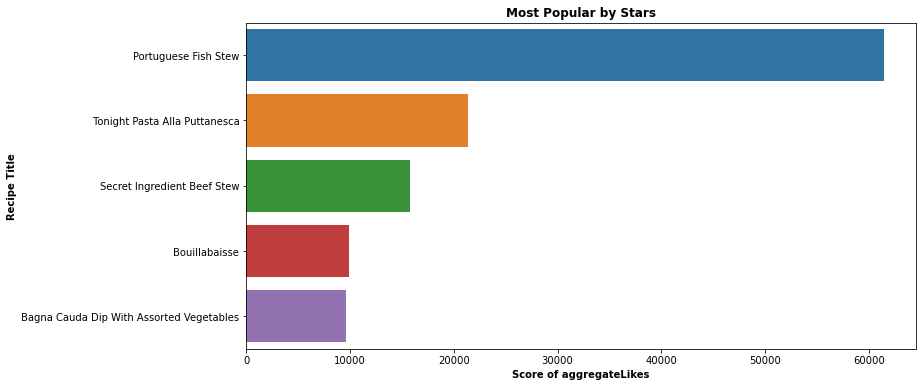

In [25]:
df=df.sort_values('aggregateLikes',ascending=False)
plt.figure(figsize=(12,6))
ax=sns.barplot(x=df['aggregateLikes'].head(5), y=df['title'].head(5), data=df)

plt.title('Most Popular by Stars', weight='bold')
plt.xlabel('Score of aggregateLikes', weight='bold')
plt.ylabel('Recipe Title', weight='bold')
plt.savefig('best_popular_recipes.png')

In [26]:
df.shape

(1722, 19)

In [27]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['title'])

tfidf_matrix.shape

(1722, 5470)

In [28]:
# http://scikit-learn.org/stable/modules/metrics.html#linear-kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

cosine_sim[0]
#cosine_sim.shape

array([1.        , 0.        , 0.10461375, ..., 0.        , 0.        ,
       0.05716812])

In [29]:
df = df.reset_index()
titles = df['title']
indices = pd.Series(df.index, index=df['title'])
#indices.head(2)

In [30]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    recipe_indices = [i[0] for i in sim_scores]
    return titles.iloc[recipe_indices]

In [31]:
get_recommendations('Garlic Parmesan Orange Roughy').head(10)

797       Orange Roughy With Lemon, Garlic And Basil
155              Orange Roughy With Citrus side dish
85                  Baked Orange Roughy With Veggies
1303                                   Parmesan Sole
1714    Toasted Parmesan And Garlic Oil Caesar salad
1458                   Broiled Tilapia With Parmesan
1330                       Parmesan & Anchovy Straws
737                Whole Mackerel With Orange Butter
846                Parmesan & Parsley-crusted Salmon
1643                             Garlic Caesar salad
Name: title, dtype: object

In [32]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    recipes_indices = [i[0] for i in sim_scores]
    
    recipes = df.iloc[recipes_indices][['title', 'aggregateLikes', 'stars', 'image']]
    aggregateLike = recipes[recipes['aggregateLikes'].notnull()]['aggregateLikes'].astype('int')
    star = recipes[recipes['stars'].notnull()]['stars'].astype('int')
    C = star.mean()
    m = aggregateLike.quantile(0.60)
    qualified = recipes[(recipes['aggregateLikes'] >= m) & (recipes['aggregateLikes'].notnull()) & 
                       (recipes['stars'].notnull())]
    qualified['aggregateLikes'] = qualified['aggregateLikes'].astype('int')
    qualified['stars'] = qualified['stars'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [33]:
improved_recommendations('Fried Anchovies with Sage')

,title,aggregateLikes,stars,image,wr
221,Cod With Sage Garlic Butter,1666,5,https://spoonacular.com/recipeImages/1397-556x...,4.287503
561,Pan-Fried Bass,1242,5,https://spoonacular.com/recipeImages/885-556x3...,4.220007
44,Pan-fried Butterfish,4244,4,https://spoonacular.com/recipeImages/1367-556x...,3.965594
130,Corn Risotto Garnished with Bacon & Anchovy Sa...,2425,4,https://spoonacular.com/recipeImages/233-556x3...,3.954535
207,Pan Fried Sea Bass,2124,4,https://spoonacular.com/recipeImages/1052-556x...,3.951981
353,Pan-fried Catfish,1434,4,https://spoonacular.com/recipeImages/1606-556x...,3.944882
493,Pan Fried Striped Bass,1313,4,https://spoonacular.com/recipeImages/862-556x3...,3.943416
583,Pan-Fried Striped Bass with Stir-Fried Tomatoe...,1242,3,https://spoonacular.com/recipeImages/918-556x3...,3.665029
42,Bap Story Stir Fried Anchovies (Myulchi Bokkeum),4245,3,https://spoonacular.com/recipeImages/4-556x370...,3.397998
74,Prosciutto-wrapped Halibut With Sage Butter si...,3453,2,https://spoonacular.com/recipeImages/1756-556x...,2.928751


In [34]:
improved_recommendations('Carrots, Cauliflower And Anchovies')

,title,aggregateLikes,stars,image,wr
483,Roasted Cauliflower With Anchovy Bread Crumbs,1324,5,https://spoonacular.com/recipeImages/37-556x37...,4.234040
66,"Orecchiette with Cauliflower, Anchovies and Pi...",3735,4,https://spoonacular.com/recipeImages/46-556x37...,3.963081
488,Baked Flounder With Parsnips And Carrots Recipe,1314,4,https://spoonacular.com/recipeImages/1392-556x...,3.943428
544,Sautaced Bass With Mint Pesto And Spiced Carrots,1242,4,https://spoonacular.com/recipeImages/951-556x3...,3.942518
713,Steamed White Fish With Julienned Carrots And ...,1124,4,https://spoonacular.com/recipeImages/1269-556x...,3.940962
767,Roasted Cauliflower With Lemon And Anchovies,1111,4,https://spoonacular.com/recipeImages/110-556x3...,3.940785
536,Striped Bass with Sweet Carrots and Cider Glaze,1242,3,https://spoonacular.com/recipeImages/940-556x3...,3.665029
487,Sake-Steamed Halibut with Dilled Carrots,1323,3,https://spoonacular.com/recipeImages/1723-556x...,3.653208
547,Seared Bass with Cauliflower Duo,1242,2,https://spoonacular.com/recipeImages/928-556x3...,3.387540
6,Roasted Salmon With Spicy Cauliflower,6766,3,https://spoonacular.com/recipeImages/282-556x3...,3.297661


Collabartive Filtering based recommendation system

It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who (s)he is.

Therefore, in this section, we will use Collaborative Filtering to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

Instead of implementing the alogrithm I will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [35]:
#Importing surprise reader
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate


In [36]:
# surprise reader API to read the dataset
reader = Reader()

In [37]:
data = Dataset.load_from_df(df[['id','userId','stars']], reader)


In [38]:
svd = SVD()

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9453  0.9993  0.9828  0.9519  0.9001  0.9559  0.0342  
MAE (testset)     0.6961  0.7098  0.7055  0.7083  0.6707  0.6981  0.0145  
Fit time          0.07    0.07    0.06    0.08    0.08    0.07    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.94532872, 0.99932935, 0.98282945, 0.95191723, 0.90011206]),
 'test_mae': array([0.69610038, 0.70981223, 0.70545931, 0.70828818, 0.6706599 ]),
 'fit_time': (0.06806325912475586,
  0.074066162109375,
  0.0620572566986084,
  0.08307600021362305,
  0.08107328414916992),
 'test_time': (0.002001047134399414,
  0.0020020008087158203,
  0.001001119613647461,
  0.0010006427764892578,
  0.0020017623901367188)}

In [39]:

data_train = data.build_full_trainset()
svd.fit(data_train)

In [40]:
df[df['userId'] == 1]

,index,id,title,veryHealthy,veryPopular,readyInMinutes,spoonacularSourceUrl,image,aggregateLikes,dishTypes,ingredients,calories,Sugar/g,stars,popularity,userId,tfdbId,recipeId,recommend,weighted_average
8,77,82,"Roasted Brussels Sprouts With Capers, Walnuts ...",True,False,45,https://spoonacular.com/roasted-brussels-sprou...,https://spoonacular.com/recipeImages/82-556x37...,6423,Maindish,"anchovies,brussels sprouts,capers,garlic clove...",611.24,14.34,5,128.655964,1,82,11,Yes,4.638481
11,18,22,Anchovy And Onion Tart,False,False,45,https://spoonacular.com/anchovy-and-onion-tart-22,https://spoonacular.com/recipeImages/22-556x37...,5524,Sidedish,"active yeast,anchovy filets,bouquet garni,flou...",453.01,8.24,3,52.035179,1,22,1936,No,3.339874
23,78,83,Labneh With Chilli And Anchovy,False,False,30,https://spoonacular.com/labneh-with-chilli-and...,https://spoonacular.com/recipeImages/83-556x37...,4646,Maindish,"anchovy fillets,bell pepper,bread,chilli,juice...",505.60,27.60,5,94.199316,1,83,12,No,4.556955
26,73,78,"Pickled Pepper, Anchovy & Egg Sandwich On Rye",False,False,45,https://spoonacular.com/pickled-pepper-anchovy...,https://spoonacular.com/recipeImages/78-556x37...,4545,Sidedish,"anchovy fillets,fresh parsley,hard-boiled eggs...",256.86,4.03,3,27.082182,1,78,6,No,3.382649
31,80,85,Pasta With Anchovy Bread Crumb Topping,False,False,45,https://spoonacular.com/pasta-with-anchovy-bre...,https://spoonacular.com/recipeImages/85-556x37...,4342,Maindish,"anchovies,cherry tomatoes,fresh parsley,garlic...",650.02,13.90,5,77.178973,1,85,16,No,4.539176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574,69,74,Salsa Verde,False,False,31,https://spoonacular.com/salsa-verde-74,https://spoonacular.com/recipeImages/74-556x37...,24,Sidedish,"anchovies,capers,extra virgin olive oil,fresh ...",503.16,0.22,4,32.319043,1,74,2,No,3.921027
1575,49,54,Anchovy and Piquillo Pepper Bruschetta,False,False,45,https://spoonacular.com/anchovy-and-piquillo-p...,https://spoonacular.com/recipeImages/54-556x37...,24,Sidedish,"anchovies,bread,caperberries,garlic clove,oliv...",151.58,1.12,4,61.196071,1,54,1979,No,3.921027
1585,37,42,Grilled Mozzarella Sandwich With Anchovy-olive...,False,False,45,https://spoonacular.com/grilled-mozzarella-san...,https://spoonacular.com/recipeImages/42-556x37...,18,Maindish,"anchovy,bread,butter,fresh mozzarella,garlic c...",702.78,4.66,3,46.985445,1,42,1962,No,3.915346
1617,103,111,Little Gem Lettuce With House Caesar Dressing,True,False,45,https://spoonacular.com/little-gem-lettuce-wit...,https://spoonacular.com/recipeImages/111-556x3...,12,Maindish,"baguette,bell pepper,champagne vinegar,dijon m...",810.28,14.22,2,35.580815,1,111,40,Yes,3.913341


In [41]:
svd.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=3.811475715127898, details={'was_impossible': False})

For Recipe with ID 302, we get an estimated prediction of 2.686. One startling feature of this recommender system is that it doesn't care what the Recipe is (or what it contains). It works purely on the basis of an assigned Recipe ID and tries to predict ratings based on how the other users have perceive the Recipe.

Hybrid recommendation system

In this section, will try to build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. 

This is how it will work:

Input: User ID and the Title of a Recipe

Output: Similar Recipes sorted on the basis of expected ratings by that particular user.

In [42]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [43]:
id_map = pd.read_csv('newfood.csv')[['recipeId', 'tfdbId']]
id_map['tfdbId'] = id_map['tfdbId'].apply(convert_int)
id_map.columns = ['recipeId', 'id']
id_map = id_map.merge(df[['title', 'id']], on='id').set_index('title')

In [44]:
indices_map = id_map.set_index('id')

In [45]:
def hybrid(userId,title):
    idx = df[df.title==title].index.values[0]
    tfdbId = df[df.title==title]['tfdbId'].values[0]
    recipe_id = df[df.title==title]['recipeId'].values[0]
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    recipe_indices = [i[0] for i in sim_scores]
    recipes = df.iloc[recipe_indices][['title','ingredients','id','recipeId']]

    recipes['est'] = recipes['recipeId'].apply(lambda x: svd.predict(userId, x).est)

    recipes = recipes.sort_values('est', ascending=False)
    return recipes.head(10)

In [46]:
import pickle
pickle.dump(cosine_sim,open("cosine_sim.pickle","wb"))
pickle.dump(svd,open("svd.pickle",'wb'))
pickle.dump(df,open("df.pickle","wb"))

In [47]:
hybrid(2,"Peruvian Fish Ceviche")

,title,ingredients,id,recipeId,est
302,Peruvian Ceviche,"butter lettuce leaves,cilantro leaves,cob corn...",1111,711,3.645738
964,Fish Chowder,"butter,celery,chicken stock,clam juice,cod,eva...",1759,1252,3.645738
104,Grilling Whole Fish,"fish,lemon,olive oil,olive oil,bell pepper,sal...",1153,1513,3.645738
1482,Fish Piccata,"butter,capers,white fish fillets,flour,fresh p...",1926,1418,3.645738
848,Fish In A Bag,"capers,dry white wine,fish,fresh sage,garlic,u...",1563,1071,3.645738
1363,Fish And Chips,"coarse salt,cod fillets,lemon wedges,low fat b...",1161,1519,3.645738
168,Fish Fusilli,"breadcrumbs,butter,canned tomatoes,cooked fusi...",1810,1303,3.645738
214,Turbot Fish in Tomato side dish (Breaded Fish ),"basil leaves,canola oil,carrot,fish,flour,garl...",1434,922,3.645738
274,Whole Fish With Mint,"fresh basil leaves,garlic,ginger,jalapeno pepp...",1097,698,3.645738
1394,Blackened Fish,"black pepper,cayenne pepper,dried thyme,dry mu...",1835,1330,3.645738


In [48]:
def hybrid(userId,title):
    idx = df[df.title==title].index.values[0]
    tfdbId = df[df.title==title]['tfdbId'].values[0]
    recipe_id = df[df.title==title]['recipeId'].values[0]
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    recipe_indices = [i[0] for i in sim_scores]
    recipes = df.iloc[recipe_indices][['title','ingredients','id','recipeId']]

    recipes['est'] = recipes['recipeId'].apply(lambda x: svd.predict(userId, x).est)
    recipes = recipes.sort_values('est', ascending=False)
    
    plt.figure(figsize=(10,4))

    ax = sns.barplot(x=recipes['est'].head(5), y=recipes['title'].head(5), data=recipes, palette='deep')

    #plt.xlim(3.55, 5.25)
    plt.title('Best Rated & Most Popular Blend', weight='bold')
    plt.xlabel('Score', weight='bold')
    plt.ylabel('Recipe Title', weight='bold')
    plt.savefig('scored_recipes.png')
    return recipes.head(10)

,title,ingredients,id,recipeId,est
302,Peruvian Ceviche,"butter lettuce leaves,cilantro leaves,cob corn...",1111,711,3.645738
964,Fish Chowder,"butter,celery,chicken stock,clam juice,cod,eva...",1759,1252,3.645738
104,Grilling Whole Fish,"fish,lemon,olive oil,olive oil,bell pepper,sal...",1153,1513,3.645738
1482,Fish Piccata,"butter,capers,white fish fillets,flour,fresh p...",1926,1418,3.645738
848,Fish In A Bag,"capers,dry white wine,fish,fresh sage,garlic,u...",1563,1071,3.645738
1363,Fish And Chips,"coarse salt,cod fillets,lemon wedges,low fat b...",1161,1519,3.645738
168,Fish Fusilli,"breadcrumbs,butter,canned tomatoes,cooked fusi...",1810,1303,3.645738
214,Turbot Fish in Tomato side dish (Breaded Fish ),"basil leaves,canola oil,carrot,fish,flour,garl...",1434,922,3.645738
274,Whole Fish With Mint,"fresh basil leaves,garlic,ginger,jalapeno pepp...",1097,698,3.645738
1394,Blackened Fish,"black pepper,cayenne pepper,dried thyme,dry mu...",1835,1330,3.645738


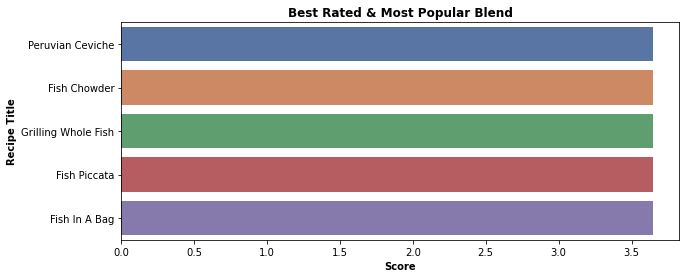

In [49]:
hybrid(2,"Peruvian Fish Ceviche")